# Loading data

In [ ]:
! wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
! unzip ml-1m.zip -d .

In [1]:
import pandas as pd
import numpy as np
import tensorflow
import tflearn

In [2]:
ratings = (pd.read_csv('./ml-1m/ratings.dat', engine='python', sep='::', names=['user', 'item', 'rating', 'timestamp'])
    .assign(timestamp=lambda df:pd.to_datetime(df.timestamp * 1000000000))
          )

movies = (pd.read_csv('./ml-1m/movies.dat', engine='python', sep='::', names=['item', 'title', 'genres'])
          .assign(genres=lambda df:df.genres.str.split('|').values)
          .set_index('item', drop=False))

# See http://files.grouplens.org/datasets/movielens/ml-1m-README.txt for more details
users = pd.read_csv('./ml-1m/users.dat', engine='python', sep='::', 
                    names=['user', 'gender', 'age', 'occupation', 'zipcode'])\
    .set_index('user', drop=False)

## Train/test split

 * Ideally time based split
 * For the sake of simplicity, let's just sample ratings uniformly (breaking the time machine rule)

In [3]:
test = ratings.sample(n=100000, random_state=0)
train_ratings_mask = ~ratings.index.isin(test.index)
train = ratings.loc[train_ratings_mask]

test_user_items = test[['user', 'item']]

print(train.shape)
print(test.shape)

test.head()

(900209, 4)
(100000, 4)


,user,item,rating,timestamp
324271,1922,2094,4,2000-11-20 04:34:27
818637,4918,2808,1,2000-07-08 19:29:05
148677,957,1660,4,2000-11-25 05:28:13
778790,4653,914,5,2000-11-29 21:22:43
525489,3245,3324,1,2000-09-07 06:33:31


In [4]:
def rmse(predicted_ratings, ground_truth_ratings=test):
    # predicted rating will be nan if no prediction => returning nan as a result if not all test ratings provided
    joined_ratings = pd.merge(
        ground_truth_ratings,
        predicted_ratings, 
        on=['user', 'item'], how='left', suffixes=['_ground_truth', '_predicted'])

    squared_errors = np.power(joined_ratings.rating_ground_truth - joined_ratings.rating_predicted, 2)
    
    return np.sqrt(np.average(squared_errors))

## Bias model in TensorFlow

Inspired by https://github.com/mesuvash/TFMF/blob/master/TFMF.ipynb and https://github.com/tensorflow/tensorflow/blob/r0.11/tensorflow/examples/tutorials/mnist/mnist.py.

In [5]:
import tensorflow as tf
import datetime as dt

N_ITEMS = ratings.item.max() + 1
N_USERS = ratings.user.max() + 1
BATCH_SIZE = 512 * 512
N_ITER = 100
LOG_DIR = '/tmp/tflearn_logs'


def inference(user_ids, item_ids):
    with tf.name_scope('user_biases'):
        user_biases =  tf.Variable(tf.truncated_normal(shape=[N_USERS, 1], stddev=0.01, mean=0), name='user_bias')
        tf.histogram_summary('user_biases', user_biases)
    with tf.name_scope('item_biases'):
        item_biases =  tf.Variable(tf.truncated_normal(shape=[N_ITEMS, 1], stddev=0.01, mean=0), name='item_bias')
        tf.histogram_summary('item_biases', item_biases)

    bias_prediction = tf.add(
        tf.squeeze(tf.nn.embedding_lookup(params=item_biases, ids=item_ids)),
        tf.squeeze(tf.nn.embedding_lookup(params=user_biases, ids=user_ids))
        )
    return bias_prediction
    
def compute_loss(predictions, targets):
    loss = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(predictions, targets))), name='rmse')
    return loss

def training(loss, learning_rate=0.01):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return train_step

def placeholder_inputs(batch_size=None):
    item_ids_placeholder = tf.placeholder(tf.int32, shape=[batch_size], name='item_ids')
    user_ids_placeholder = tf.placeholder(tf.int32, shape=[batch_size], name='user_ids')
    ratings_placeholder = tf.placeholder(tf.float32, shape=[batch_size], name='ratings')
    return user_ids_placeholder, item_ids_placeholder, ratings_placeholder

with tf.Graph().as_default():
    user_ids_placeholder, item_ids_placeholder, ratings_placeholder = placeholder_inputs()
    
    predictions = inference(user_ids_placeholder, item_ids_placeholder)
    
    loss = compute_loss(predictions, ratings_placeholder)
    tf.scalar_summary('batch_rmse', loss)
    summary = tf.merge_all_summaries()
    test_summary = tf.scalar_summary('test_rmse', loss)

    train_step = training(loss)

    def perform_step(step, train, test):
        sample_train_ratings = train.sample(BATCH_SIZE)
        _, loss_value, summary_value = sess.run(
            fetches=[train_step, loss, summary], 
            feed_dict={
                user_ids_placeholder: sample_train_ratings.user.values,
                item_ids_placeholder: sample_train_ratings.item.values,
                ratings_placeholder: sample_train_ratings.rating.values
            })
        summary_writer.add_summary(summary_value, global_step=step)

        if step % 10 == 0:
            test_loss_value, test_summary_value = sess.run(
                fetches=[loss, test_summary],
                feed_dict={
                    user_ids_placeholder: test.user.values,
                    item_ids_placeholder: test.item.values,
                    ratings_placeholder: test.rating})
            print('Step %d: batch/test loss = %.2f/%.2f' % (step, loss_value, test_loss_value))
            summary_writer.add_summary(test_summary_value, global_step=step)

        summary_writer.flush()
        
    with tf.Session() as sess:
        summary_writer = tf.train.SummaryWriter(LOG_DIR + '/{:%Y%m%d%H%M%S}'.format(dt.datetime.now()), sess.graph)

        sess.run(tf.initialize_all_variables())
        
        for step in range(N_ITER):
            perform_step(step, train, test)
            
        test_prediction_values = predictions.eval(feed_dict={
                    user_ids_placeholder: test.user.values,
                    item_ids_placeholder: test.item.values})

Step 0: batch/test loss = 3.75/3.54
Step 10: batch/test loss = 1.86/1.72
Step 20: batch/test loss = 1.20/1.20
Step 30: batch/test loss = 1.06/1.05
Step 40: batch/test loss = 0.96/0.97
Step 50: batch/test loss = 0.93/0.93
Step 60: batch/test loss = 0.92/0.92
Step 70: batch/test loss = 0.90/0.91
Step 80: batch/test loss = 0.90/0.91
Step 90: batch/test loss = 0.90/0.91


In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_predicted_distribution(predicted_ratings, ground_truth_ratings=test):
    bins = np.linspace(-.5, 7.5, 9)
    plt.hist(predicted_ratings.rating, 
             bins=bins, normed=True, histtype='step', lw=2, label='predicted')
    plt.hist(ground_truth_ratings.rating, 
             bins=bins, normed=True, histtype='step', lw=2, color='grey', label='ground truth')
    plt.ylabel('rating proportion')
    plt.xlabel('rating value')
    plt.xlim([0, 6]); plt.ylim([0, 1.05])
    plt.xticks(range(1, 6))
    plt.legend(loc=2)

0.909764249702


,item,rating,user
324271,2094,2.973603,1922
818637,2808,2.237526,4918
148677,1660,3.978423,957
778790,914,3.797417,4653
525489,3324,2.226793,3245


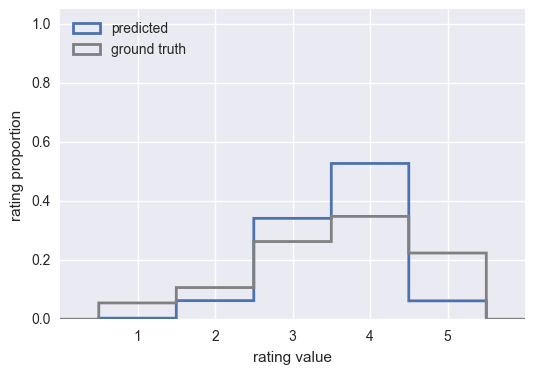

In [8]:
predicted_ratings = pd.DataFrame.from_dict(
    {'user': test_user_items.user,
     'item': test_user_items.item,
     'rating': test_prediction_values
    })

print(rmse(predicted_ratings))

plot_predicted_distribution(predicted_ratings)
predicted_ratings.head()